In [73]:
# import necessary libraries 

import pyarrow
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers, models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model

from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [74]:
# read the dataset
data = pd.read_parquet('FEData_For_Modelling.parquet').reset_index(drop = True)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


In [75]:
# identify malicious users
import os
malicious_filenames = os.listdir('answers/r5.2-2')
malicious_users = []

for filename in malicious_filenames:
    malicious_users.append(filename.replace('r5.2-2-', "").replace('.csv', ""))

malicious_users

['MDS0680',
 'GWG0497',
 'CKP0630',
 'HMS1658',
 'BYO1846',
 'HXP0976',
 'CIF1430',
 'ITA0159',
 'OSS1463',
 'SNK1280',
 'HIS1394',
 'SIS0042',
 'HSN0675',
 'MCP0611',
 'TNB1616',
 'CHP1711',
 'MGB1235',
 'NAH1366',
 'JAL0811',
 'OKM1092',
 'TMT0851',
 'DCC1119',
 'KSS1005',
 'VCF1602',
 'RRS0056',
 'WDT1634',
 'ICB1354',
 'ZIE0741',
 'LVF1626',
 'TRC1838']

In [76]:
# label malicious and non malicious
data['malicious'] = np.where(data['user'].isin(malicious_users), 1, 0)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [77]:
column_names = data.columns.tolist()
print(column_names)

['user', 'O', 'C', 'E', 'A', 'N', 'FCwke', 'FCowh', 'FCwh', 'SDwke', 'SDowh', 'SDwh', 'CDwke', 'CDowh', 'CDwh', 'JDwke', 'JDowh', 'JDwh', 'malicious']


In [78]:
from collections import Counter

X = data.drop(columns = ['user', 'malicious'])
y = data.malicious

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


In [79]:
X_column_names = X.columns.tolist()
print(X_column_names)

['O', 'C', 'E', 'A', 'N', 'FCwke', 'FCowh', 'FCwh', 'SDwke', 'SDowh', 'SDwh', 'CDwke', 'CDowh', 'CDwh', 'JDwke', 'JDowh', 'JDwh']


In [80]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(sampling_strategy=0.5) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 787})


In [81]:
# Standardize features, using minmax and not standardscale -> got dif??
scaler = MinMaxScaler()
resampled_X_train = scaler.fit_transform(resampled_X_train)
X_test = scaler.transform(X_test)
print(resampled_X_train.shape, X_test.shape)

(2361, 17) (400, 17)


In [82]:
# let model train on normal data only, test using total dataset
train_labels = resampled_y_train.astype(bool)
test_labels = y_test.astype(bool)

normal_train_data = resampled_X_train[train_labels]
normal_test_data = X_test[test_labels]

anomalous_train_data = resampled_X_train[~train_labels]
anomalous_test_data = X_test[~test_labels]

print(normal_train_data.shape, normal_test_data.shape, anomalous_train_data.shape, anomalous_test_data.shape)

(787, 17) (4, 17) (1574, 17) (396, 17)


## Building the model

In [83]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'), 
            tf.keras.layers.Dense(8, activation='relu'), # 8 units is the bottleneck layer
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(17, activation='sigmoid'), # input shape is 17, output shape has to be the same
        ])

        # nonlinear activation

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded    

In [84]:
model = AutoEncoder()  
opt = Adam(learning_rate=0.01)   
model.compile(optimizer = opt, loss = 'mae', metrics = ['mae', 'acc'])

In [85]:
history = model.fit(normal_train_data, normal_train_data,
                    epochs = 50,
                    batch_size = 64,
                    validation_data = (resampled_X_train, resampled_X_train),
                    shuffle = True,
                    #callbacks = [early_stopping]
                    )

Epoch 1/50


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - acc: 0.3876 - loss: 0.2953 - mae: 0.2953 - val_acc: 0.3371 - val_loss: 0.1027 - val_mae: 0.1027
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.3453 - loss: 0.0801 - mae: 0.0801 - val_acc: 0.1906 - val_loss: 0.0906 - val_mae: 0.0906
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.3975 - loss: 0.0691 - mae: 0.0691 - val_acc: 0.3371 - val_loss: 0.0825 - val_mae: 0.0825
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.4038 - loss: 0.0643 - mae: 0.0643 - val_acc: 0.3371 - val_loss: 0.0773 - val_mae: 0.0773
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.4461 - loss: 0.0553 - mae: 0.0553 - val_acc: 0.3537 - val_loss: 0.0738 - val_mae: 0.0738
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.4463 - loss: 0.0530 - mae: 0.0530 - val_acc: 0.3685 - val_loss: 0.0737 - val_mae: 0.0737
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.4115 - loss: 0.0517 - mae: 0.0517 - val_acc: 0.3803 - val

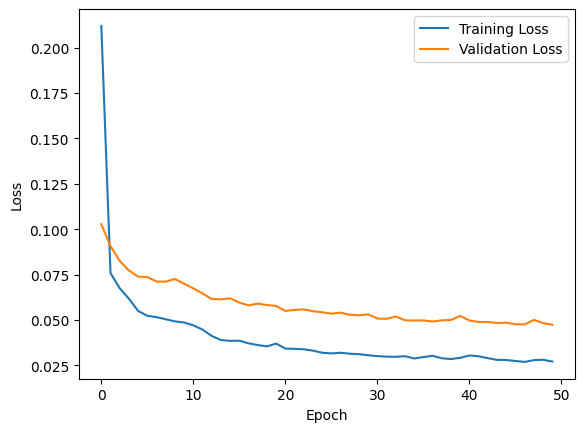

In [86]:
# loss plot
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

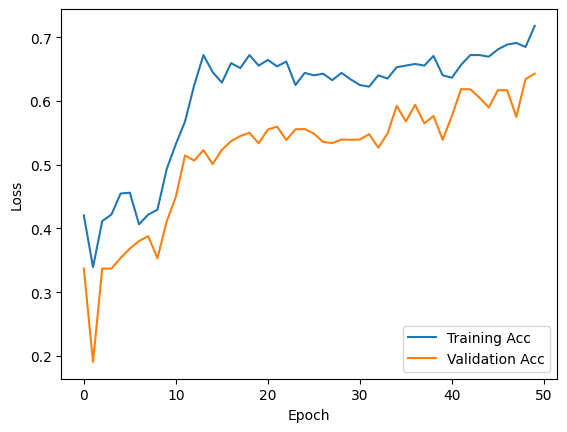

In [87]:
# acc plot
plt.plot(history.history["acc"], label="Training Acc")
plt.plot(history.history["val_acc"], label="Validation Acc")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [88]:
test_x_predictions = model.predict(X_test)
print(test_x_predictions.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(400, 17)


In [89]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(resampled_X_train, resampled_y_train)
y_pred = logreg.predict(test_x_predictions)
y_pred_prob = logreg.predict_proba(test_x_predictions)

Accuracy = 82.25%
Precision = 0.028169014084507043
Recall = 0.5
f-1 score = 0.05333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       396
           1       0.03      0.50      0.05         4

    accuracy                           0.82       400
   macro avg       0.51      0.66      0.48       400
weighted avg       0.98      0.82      0.89       400



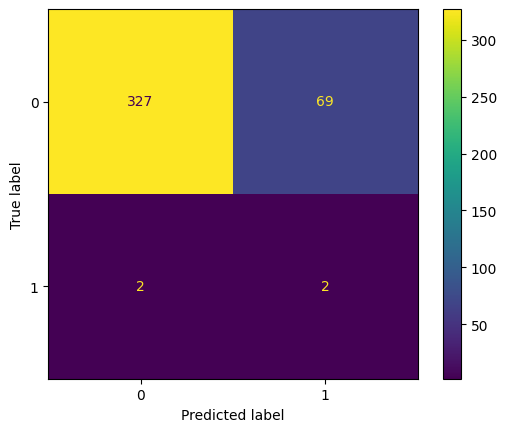

In [90]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision = {}".format(precision_score(y_test, y_pred)))
print("Recall = {}".format(recall_score(y_test, y_pred)))
print("f-1 score = {}".format(f1_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot()
plt.show()

### identifying true negatives

In [91]:
# FINDING TN
# Create a DataFrame to store predictions and actual labels
predictions_df = pd.DataFrame({'actual_label': y_test, 'predicted_label': y_pred})

# Filter false positive instances (predicted_label == 1 and actual_label == 1)
# bottom left box -> FN???
true_negative_df = predictions_df[(predictions_df['predicted_label'] == 1) & (predictions_df['actual_label'] == 1)]

# Display false positive instances
print(true_negative_df)
true_negative_df.shape

tn_index = list(true_negative_df.index)
print(tn_index)

      actual_label  predicted_label
1813             1                1
1274             1                1
[1813, 1274]


In [92]:
# Filter rows with specific indices from the original DataFrame
filtered_tn = data.loc[tn_index]

# Print the filtered DataFrame
print(filtered_tn)
filtered_tn.shape

         user   O   C   E   A   N  FCwke  FCowh  FCwh  SDwke  SDowh  SDwh  \
1813  TNB1616  33  38  10  43  29      0     12    61      0    206   605   
1274  MCP0611  19  19  19  45  29      0      5   226      0      1    19   

      CDwke  CDowh  CDwh  JDwke  JDowh  JDwh  malicious  
1813      0      9    15      0    123   248          1  
1274      0      0     0      0     55    58          1  


(2, 19)

### identifying true positives

In [93]:
# FINDING TP
# Create a DataFrame to store predictions and actual labels
predictions_df = pd.DataFrame({'actual_label': y_test, 'predicted_label': y_pred})

# Filter false positive instances (predicted_label == 0 and actual_label == 0)
# bottom left box -> FN???
true_positive_df = predictions_df[(predictions_df['predicted_label'] == 0) & (predictions_df['actual_label'] == 0)]

# Display false positive instances
print(true_positive_df)
true_positive_df.shape

tp_index = list(true_positive_df.index)
print(tp_index)

      actual_label  predicted_label
1860             0                0
353              0                0
1333             0                0
905              0                0
1289             0                0
...            ...              ...
534              0                0
965              0                0
1739             0                0
261              0                0
535              0                0

[327 rows x 2 columns]
[1860, 353, 1333, 905, 1289, 938, 1731, 65, 1323, 56, 1292, 1118, 584, 374, 275, 128, 1646, 1852, 674, 1664, 1083, 1179, 964, 792, 628, 907, 1080, 1609, 1078, 254, 124, 1927, 585, 1568, 824, 507, 70, 1608, 1532, 247, 1450, 212, 909, 1741, 1696, 1182, 361, 678, 1089, 1987, 1847, 987, 111, 1487, 1453, 383, 755, 324, 1623, 787, 368, 1819, 69, 857, 1483, 1555, 1691, 1474, 1798, 478, 1556, 1729, 210, 297, 1884, 651, 1233, 1931, 916, 993, 429, 1370, 239, 620, 256, 611, 544, 771, 1419, 1041, 1789, 759, 382, 1103, 352, 1825, 1107, 494, 393, 1546,

In [94]:
# Filter rows with specific indices from the original DataFrame
filtered_tp = data.loc[tp_index]

# Print the filtered DataFrame
print(filtered_tp)
filtered_tp.shape

         user   O   C   E   A   N  FCwke  FCowh  FCwh  SDwke  SDowh  SDwh  \
1860  VAH1292  14  23  40  25  31      0     13     0      2      4   365   
353   CJL0143  23  42  27  19  28      0      0     0      0    145  3184   
1333  MMB1967  20  15  38  14  27      0      0     0      0      0    12   
905   IVS1411  34  22  23  15  25      0      0     0      0      9    87   
1289  MEB1743  33  39  18  33  30      0     86   307      0      2     8   
...       ...  ..  ..  ..  ..  ..    ...    ...   ...    ...    ...   ...   
534   DTB0722  46  38  24  30  27      0      0     0      0      4   389   
965   JIG1593  42  20  28  17  27      0      0     0      0      1    10   
1739  SSG0726  40  18  35  21  32      0      0     0      0      1   105   
261   BWJ1539  25  43  45  36  33     31     38   176      0      0     2   
535   DTB0964  26  49  18  40  27      0      0     0      0     12   231   

      CDwke  CDowh  CDwh  JDwke  JDowh  JDwh  malicious  
1860      0      

(327, 19)

### identifying false negatives

In [95]:
# Create a DataFrame to store predictions and actual labels
predictions_df = pd.DataFrame({'actual_label': y_test, 'predicted_label': y_pred})

# Filter false positive instances (predicted_label == 0 and actual_label == 1)
# bottom left box -> FN???
false_negative_df = predictions_df[(predictions_df['predicted_label'] == 0) & (predictions_df['actual_label'] == 1)]

# Display false positive instances
print(false_negative_df)
false_negative_df.shape

fn_index = list(false_negative_df.index)
print(fn_index)

      actual_label  predicted_label
1473             1                0
1810             1                0
[1473, 1810]


In [96]:
# Filter rows with specific indices from the original DataFrame
filtered_fn = data.loc[fn_index]

# Print the filtered DataFrame
print(filtered_fn)
filtered_fn.shape


         user   O   C   E   A   N  FCwke  FCowh  FCwh  SDwke  SDowh  SDwh  \
1473  OKM1092  11  34  38  15  27      0    105   244      0      0     0   
1810  TMT0851  39  39  16  25  25      0     35    77      0      8    20   

      CDwke  CDowh  CDwh  JDwke  JDowh  JDwh  malicious  
1473      0      1     8      0    108   232          1  
1810      0    488  1491      0    311   816          1  


(2, 19)

### identifying false positives

In [97]:
# Create a DataFrame to store predictions and actual labels
predictions_df = pd.DataFrame({'actual_label': y_test, 'predicted_label': y_pred})

# Filter false positive instances (predicted_label == 1 and actual_label == 0)
# top right box
false_positive_df = predictions_df[(predictions_df['predicted_label'] == 1) & (predictions_df['actual_label'] == 0)]

# Display false positive instances
print(false_positive_df)
false_positive_df.shape

fp_index = list(false_positive_df.index)
print(fp_index)

      actual_label  predicted_label
1273             0                1
746              0                1
1981             0                1
1922             0                1
99               0                1
...            ...              ...
1563             0                1
1460             0                1
1658             0                1
730              0                1
1284             0                1

[69 rows x 2 columns]
[1273, 746, 1981, 1922, 99, 29, 944, 572, 450, 1290, 251, 889, 1244, 1621, 1512, 1395, 1054, 281, 1647, 1833, 1502, 879, 973, 1605, 1036, 886, 1893, 1699, 1313, 530, 654, 617, 1242, 1345, 874, 1225, 602, 270, 1872, 720, 1766, 1137, 354, 1245, 100, 1027, 552, 538, 1423, 1911, 1301, 581, 937, 974, 1686, 990, 438, 1518, 1736, 1600, 1610, 123, 1378, 1592, 1563, 1460, 1658, 730, 1284]


In [98]:
# Filter rows with specific indices from the original DataFrame
filtered_fp = data.loc[fp_index]

# Print the filtered DataFrame
print(filtered_fp)
filtered_fp.shape

         user   O   C   E   A   N  FCwke  FCowh  FCwh  SDwke  SDowh  SDwh  \
1273  MCL1953  40  16  42  47  30      0      0     0      0      0     0   
746   HCV0286  38  27  10  21  26      0      0     0      0     12    36   
1981  ZHB1104  34  14  23  18  31      0      0     0      0      3     3   
1922  WSK1857  40  18  32  40  34      0     15     0      0      8    14   
99    AMC1724  19  19  22  41  24      0      0     0      0     27   130   
...       ...  ..  ..  ..  ..  ..    ...    ...   ...    ...    ...   ...   
1563  RAS1982  33  35  16  44  31      0      0     0      0      0     0   
1460  OFB1017  48  21  23  18  37      0      0     0      0      4   445   
1658  SBP1176  39  17  20  37  34      0      0     0      0    351  2101   
730   HBD0788  43  19  47  46  33      0      0     0      0      2    12   
1284  MDL0294  39  20  24  40  24      0      0     0      0     41   104   

      CDwke  CDowh  CDwh  JDwke  JDowh  JDwh  malicious  
1273      0      

(69, 19)

### using encoder to predict test data
### use predictions as training dataset for logreg classifier
### tune with gridsearchcv and evaluate

In [99]:
# model.encoder
compressed_X_test = model.encoder.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Initialize Logistic Regression classifier
logreg = LogisticRegression()

# Define hyperparameters to tune using GridSearchCV
param_grid = {'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01], 'penalty': ['l2']}

# Initialize GridSearchCV with the classifier and hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=10, scoring='accuracy')

# Fit the classifier using the compressed test data
grid_search.fit(compressed_X_test, y_test)

/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01],
                         'penalty': ['l2']},
             scoring='accuracy')

In [101]:
from sklearn.metrics import classification_report

# Get the best estimator from GridSearchCV
best_logreg = grid_search.best_estimator_

# Use the best classifier to predict on test data
y_pred = best_logreg.predict(compressed_X_test)


Accuracy: 99.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

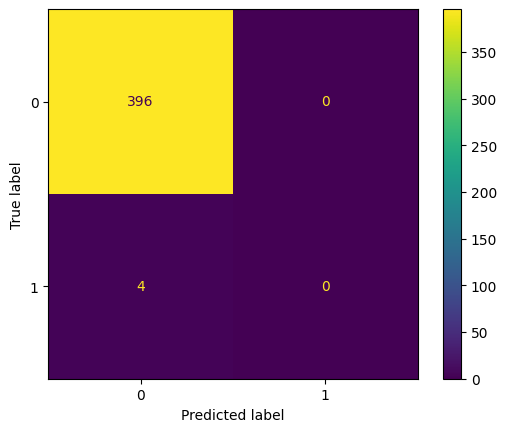

In [102]:
# Evaluate the model
best_logreg.fit(resampled_X_train, resampled_y_train)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Evaluate the classifier using classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot()
plt.show()

### using entire autoencoder to predict test data
### then use these predictions as a training dataset for a logreg classifier
### tune with gridsearchcv

In [103]:
# Assuming you have an autoencoder model named 'autoencoder_model'
reconstructed_X_test = model.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [104]:
# Flatten the reconstructed data
flattened_X_test = reconstructed_X_test.reshape(reconstructed_X_test.shape[0], -1)


In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Initialize Logistic Regression classifier
logreg = LogisticRegression()

# Define hyperparameters to tune using GridSearchCV
param_grid = {'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01], 'penalty': ['l2']}

# Initialize GridSearchCV with the classifier and hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=3, scoring='accuracy')

# Fit the classifier using the flattened reconstructed test data
grid_search.fit(flattened_X_test, y_test)


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01],
                         'penalty': ['l2']},
             scoring='accuracy')

In [106]:
from sklearn.metrics import classification_report

# Get the best estimator from GridSearchCV
best_logreg = grid_search.best_estimator_

# Use the best classifier to predict on test data
y_pred = best_logreg.predict(flattened_X_test)

# Evaluate the classifier using classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [107]:
best_logreg

LogisticRegression(C=1e-07)

/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Accuracy: 99.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



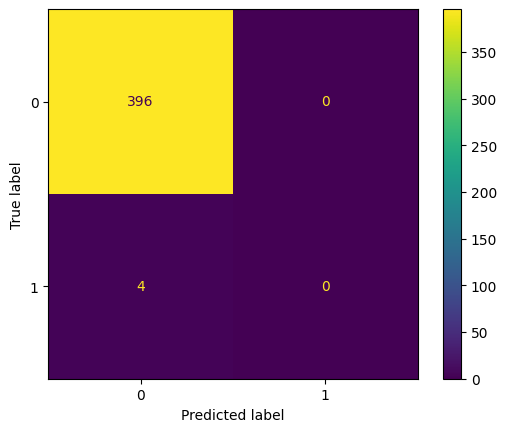

In [108]:
# Evaluate the model
best_logreg.fit(resampled_X_train, resampled_y_train)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot()
plt.show()

### feature importance?

In [109]:
from sklearn.feature_selection import RFECV

# Feature Selection
rfe = RFECV(estimator = logreg, scoring = 'precision') #minimises false positives
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

print('Chosen best features by rfe:', X_train.columns[rfe.support_].tolist())
print('Ranking of Feature Importance:', rfe.ranking_)

/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWar

Chosen best features by rfe: ['N']
Ranking of Feature Importance: [ 2  3  4 15  1  8  9 17 14  7 10 13 11 12  6  5 16]


/Users/shian/opt/anaconda3/envs/DSA4263/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


In [110]:
best_logreg = grid_search.best_estimator_

# Use encoder part of the autoencoder for feature selection

encoded_features_train = model.encoder.predict(X_train)
encoded_features_test = model.encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Encoded Features Shape (Train): (1600, 8)
Encoded Features Shape (Test): (400, 8)


In [111]:
# Import a predictive model (e.g., logistic regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Fit a logistic regression model using the selected features
model = LogisticRegression()
model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred = model.predict(encoded_features_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Selected Features:", accuracy)

Accuracy with Selected Features: 0.99


<Axes: >

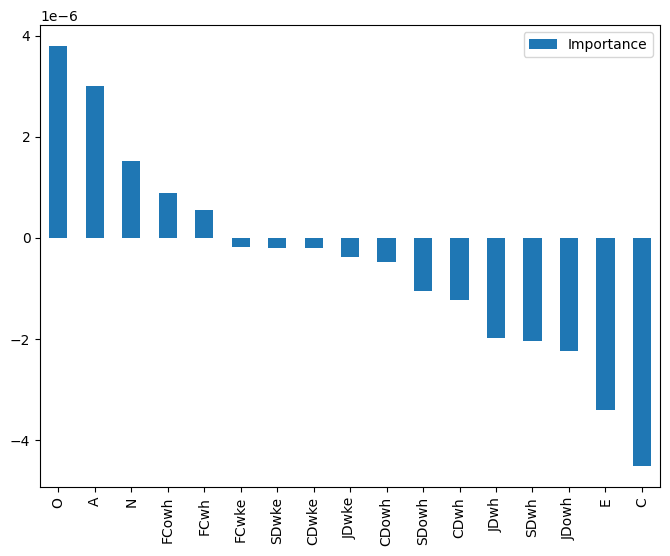

In [112]:
# feature importance

feat_importances = pd.DataFrame(best_logreg.coef_[0], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))